# Эффективные алгоритмы для SVMs

# Effective algorithms for SVM model

В этой задаче мы будем решать задачу SVM.
Для того, чтобы осознать, что это актуально и активно исследуется, можно посмотреть например на эту статью:
https://papers.nips.cc/paper/8856-unixgrad-a-universal-adaptive-algorithm-with-optimal-guarantees-for-constrained-optimization.pdf
Это статья с NeurIPS (ТОП-1 конференции по машинному обучению) от Френсиса Баха (одного из самых цитируемых людей в оптимизации для ML).

Если Вы не знаете, что такое SVM и как он работает, можно посмотреть, например тут:
https://habr.com/ru/company/ods/blog/484148/
и в ссылках к этой статье.

Нас интересует решение задачи:
$$
\min_{w \in R^n, \zeta \in R^k, b \in R}\frac{1}{2}\|w\|_2^2 + \alpha \sum_{i=1}^k \zeta_i \\
y^{(i)} (w^Tx^{(i)} - b) \geq 1-\zeta_i \quad \forall 1\leq i\leq k\\
\zeta_i \geq 0 \quad \forall 1 \leq i \leq k
$$

Если простыми словами, то у нас есть $k$ точек $(x^{(i)}, y^{(i)})$ ($1 \leq i \leq k$) в пространстве $R^n \times R$.  Соответственно, индекс $i$ - Это просто "номер" точки. Здесь $x$ отвечает за признаки, а $y \in {-1, 1}$ - лейблы (метки), которые указывают на "класс" точки (соответственно, для точек из одного класса $y=1$, а для другого $y=-1$).

SVM пытается используя информацию о заданных $k$ точках построить правило, которое делило бы все точки пространства на два класса. При этом здесь предполагается, что точки на два класса можно разделить с помощью гиперплоскости. Как Вы знаете, гиперплоскость задается двумя параметрами: вектором (в этой задаче $w \in R^n$) и константой (здесь $b \in R$).

Их мы и пытаемся найти в этой задаче.

Если бы наша выборка была бы линейно разделима (то есть существует гиперплоскость, такая, что точки из разных классов лежат по разные стороны гиперплоскости), то $\zeta=0$. Но не всегда точки разделимы (например, из-за шума). Поэтому мы написали SVM с мягкими ограничениями, то есть просто штрафуя за нарушения (то есть за попадание точки одного класса на часть пространства, которая относится к другому классу) пропорционально нарушению.

Ок, с объяснением задачи закончили.
Теперь про методы...


Вы изучили достаточно много методов для решения таких задач:


*   Реализуйте метод проксимального градиентного спуска для этой задачи (3 балла)
*   Реализуйте метод ADMM для этой задачи (3 балла)


*   Реализуйте быстрый градиентный спуск используя метод сглаживания (5 баллов)
*   Реализуйте метод субградиентного спуска для этой задачи (3 балла)


*   Представьте эту задачу в виде, для которого можно использовать метод условного градиента или метод проекции градиента. Реализуйте их (3 балла).




*   Проведите расчеты для данных breast-cancer (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) (3 балла)
*   Сравните скорость сходимости методов для этого инстанса задачи (то есть конкретно для этого набора данных) (2 балла)


# Data reading

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [5]:
l = 683 #количество объектов 
n = 10 #количество признаков

In [6]:
y = np.zeros((l,))
X = np.zeros((l, n))

In [7]:
f = open('task.txt', 'r')
for i, line in enumerate(f):
    line = line.split(' ')
    for c in line:
        if c == '4':
            y[i] = 1
        elif c == '2':
            y[i] = -1
        elif c == '\n':
            continue
        else:
            c = c.split(':')
            X[i][int(c[0]) - 1] = float(c[1])

In [8]:
print(X[0], '|', y[0])

[-0.860107 -0.111111 -1.       -1.       -1.       -0.777778 -1.
 -0.555556 -1.       -1.      ] | -1.0


In [9]:
print(X.shape, y.shape)

(683, 10) (683,)


In [10]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C = 1)
clf.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
clf.coef_

array([[ 0.11648444,  1.00816373, -0.02627667,  0.78272263,  0.38716858,
         0.4264855 ,  0.78479364,  0.73213793,  0.42070285,  0.65788851]])

In [16]:
clf.coef0

0.0

In [38]:
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.9707174231332357

# Proximal descent

В данной задаче метод проксимального спуска не применим. Связано это с тем, что в методе проксимального спуска прокс-функция для негладкой функции должна находится аналитически. Здесь же все это усложняется тем, что негладкая функция представлена в виде суммы негладких функций, что очень усложняет задачу для решения методом проксимального спуска.

Поэтому я попытался применить несколько эвристик. Первое найти прокс-функцию не всей негладкой функции, а представить ее как среднее прокс-функций каждого слагаемого в сумме (метод усредненного градиентного спуска):

$$\text{prox}_g = \frac{1}{\ell}\sum\limits_{i=1}^{\ell} \text{prox}_{f_i},$$

однако такая эвристика также не помогла. Поэтому пока оставим метод проксимального спуска.

# ADMM

ADMM в том виде, который был предложен на семинаре здесь также не применим, т.к. снова не ищется аналитически шаг для $w$, поэтому реализуем метод, предложенный в книге Proximal Algorithms, Boyd.

Нам нужно решить эквивалентную задачу:

$$\min\limits_{w, w_0} \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}\left[1 - y_i(w^Tx_i - w_0)\right]_+ = \min\limits_{w, w_0} f(w) + \hat{h}(w, w_0),$$
где $[x]_+$ означает положительную срезку. Введем следующую матрицу $A$:

$$A = \begin{pmatrix}
y_1x_1^1 & y_1x_1^2 & y_1x_1^3 & \dots & y_1x^n_1 & -y_1\\
y_2x_2^1 & y_2x_2^2 & y_2x_2^3 & \dots & y_2x^n_2 & -y_2\\
y_3x_3^1 & y_3x_3^2 & y_3x_3^3 & \dots & y_3x^n_3 & -y_3\\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
y_{\ell}x_{\ell}^1 & y_{\ell}x_{\ell}^2 & y_{\ell}x_{\ell}^3 & \dots & y_{\ell}x^n_{\ell} & -y_{\ell}\\
\end{pmatrix} = \begin{pmatrix} a_1\\
a_2 \\
a_3\\
\vdots\\
a_{\ell}\end{pmatrix} \in \mathbb{R}^{\ell\times (n+1)}.$$

Тогда задачу можно переписать в виде:

$$\min\limits_{w, w_0} \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}\left[1 - a_i\begin{pmatrix}w\\
w_0\end{pmatrix}\right]_+ = f(w,w_0) + h\left(A\begin{pmatrix}w\\w_0 \end{pmatrix}\right).$$ 



Здесь уже функция $h$ имеет более приятный вид: $h(z) = \alpha\sum\limits_{i=1}^{\ell} (1-z_i)_+$. Сделаем замену  $A\begin{pmatrix}w\\w_0\end{pmatrix}=z.$ Тогда получим задачу, пригодную для ADMM:

$$\min\limits_{w, w_0,z} f(w) + h(z)\\
z = A\begin{pmatrix} w\\w_0\end{pmatrix} = A\hat{w}.$$

Далее будем пользоваться linearized ADMM, описанным в книге Бойда: https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf (пункт 4.4.2). Шаги этого метода имеют вид:

- $w^{k+1} = \text{prox}_{\mu f}\left[w^k-(\mu/\lambda)A^T(Aw^k-z^k+u^k)\right];$

- $z^{k+1} = \text{prox}_{\lambda h}\left[Aw^{k+1}+u^k\right];$

- $u^{k+1} = u^k + Aw^{k+1} -z^{k+1}.$

Нужно теперь найти две prox-функции. Напомню, что $f(w) = \frac{1}{2}\|w\|^2_2, h(z) = \alpha\sum\limits_{i=1}^{\ell} (1-z_i)_+$. Найдем первую prox-функцию:

$$\text{prox}_{\mu f}(v, v_0) = \text{argmin}_x \left[f(x) + \frac{\mu}{2}\|(x, x_0)^T -(v, v_0)^T\|^2_2\right] =\text{argmin}_x \left[\frac{1}{2}\|x\|_2^2 + \frac{\mu}{2}\|x -v\|^2_2 + \frac{\mu}{2}(x_0 - v_0)^2\right].$$

Условие оптимальности по $x$ имеет вид: $x + \mu(x-v) = 0 \Rightarrow x = \frac{\mu}{1+\mu} v$. Оптимальное $x_0 = v_0$. Тогда первая prox-функция имеет вид:

$$\text{prox}_{\mu f}(v, v_0) = \left(\frac{\mu}{1+\mu}v, v_0\right)^T.$$

Найдем вторую prox-функцию. Она будет сепарабельна по переменным, запишем задачу, которую нужно решить для одной переменной:

$$\text{argmin}_{x_i}\left[\alpha(1-x_i)_+ + \frac{\lambda}{2}(x_i -v_i)^2\right].$$

Отсюда условие оптимальности по $x_i$ имеет вид:

$$\begin{cases} -\alpha,\qquad x_i < 1\\
[-\alpha, 0], ~~~x_i = 1\\
0, \qquad~~~ x_i > 1\end{cases} + \lambda x_i - \lambda v_i = 0 \Rightarrow x_i = \begin{cases}v_i + \alpha/\lambda,\qquad v_i < 1- \alpha/\lambda\\
1, \qquad\qquad~~ v_i \in [1-\alpha/\lambda, 1]\\
v_i, \qquad\qquad~ v_i > 1\end{cases}$$

In [27]:
mu = 100
lmbd = 10000
alp = 100
lmbd *=alp

In [27]:
A = np.zeros((l, n+1))
for i in range(l):
    for j in range(n):
        A[i][j] = y[i]*X[i][j]
    A[i][n] = -y[i]


print(A)

def L(w):
    v=w[:-1]
    v_0 = w[-1]
    ans = 1/2*np.linalg.norm(v)**2
    for i, x_i in enumerate(X):
        if (1 - y[i]*v.T.dot(x_i) + y[i]*v_0 >= 0):
            ans += alp*(1 - y[i]*v.T.dot(x_i) + y[i]*v_0)
    return ans

[[ 0.860107  0.111111  1.       ...  1.        1.        1.      ]
 [ 0.859671  0.111111  0.333333 ...  0.777778  1.        1.      ]
 [ 0.857807  0.555556  1.       ...  1.        1.        1.      ]
 ...
 [-0.876716 -0.111111  1.       ...  1.       -0.777778 -1.      ]
 [-0.875424 -0.333333  0.555556 ...  0.111111 -1.       -1.      ]
 [-0.875424 -0.333333  0.555556 ... -0.333333 -1.       -1.      ]]


In [28]:
def prox_f(v):
    ans = np.zeros(n+1)
    for i in range(n):
        ans[i] = mu/(1+mu)*v[i]
    ans[n] = v[n]
    return ans

def prox_h(v):
    ans = np.zeros(l)
    for i in range(l):
        if (v[i] < 1 - 1/lmbd):
            ans[i] = v[i] + 1/lmbd
        elif (v[i] >= 1- 1/lmbd and v[i] <= 1):
            ans[i] = 1
        elif (v[i] > 1):
            ans[i] = v[i]
    return ans

def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

In [415]:
func_admm = []
weights_admm = []
accuracy_admm = []

u = np.zeros(l)
w = np.ones(n+1)
w[-1] = 0
z = np.ones(l)

eps = L(w)
func_admm.append(eps)

for i in range(125):
    w = prox_f(w - mu/lmbd*A.T.dot(A.dot(w) - z+ u))
    z = prox_h(A.dot(w) + u)
    u = step_svm_u(u, w, z)
    eps = L(w)
    func_admm.append(eps)
    a = accuracy_score(y, predict(X.dot(w[:-1])-w[-1]))
    accuracy_admm.append(a)

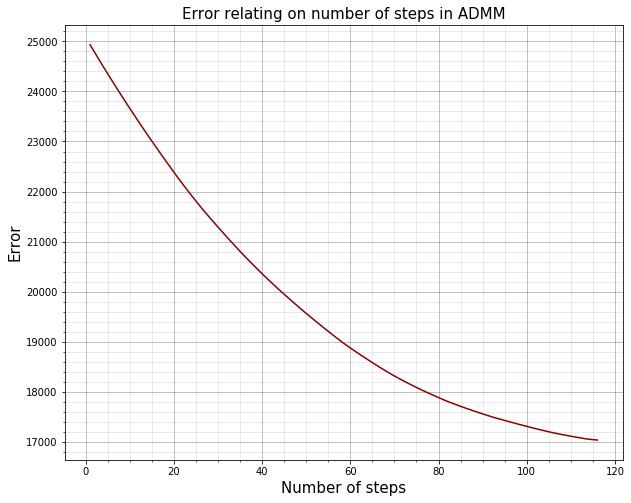

In [416]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(func_admm[10:])), func_admm[10:], color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

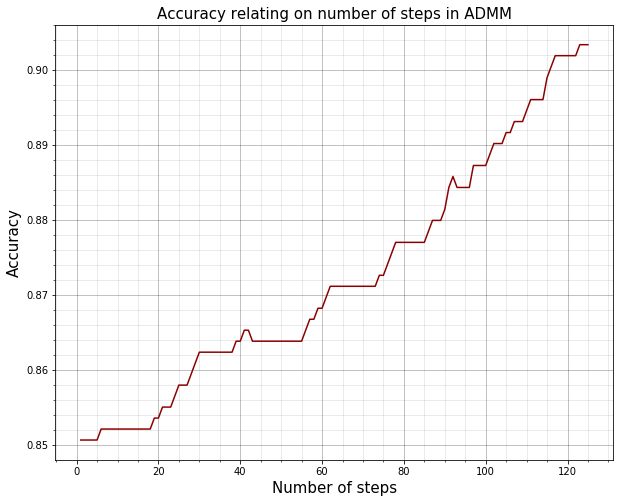

In [417]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy_admm)), accuracy_admm, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Fast gradient descent with smoothing technique

Запишем задачу, используя технику сглаживания:
$$f_{\mu}(w) = \frac{1}{2}\|w\|^2_2 + \max\limits_{0\leq \textbf{u} \leq 1}\left[\alpha\sum\limits_{i=1}^{\ell}u_i\left(1-y_i(w^Tx_i-w_0)\right) - \frac{\mu}{2}\|u\|^2_2\right].$$

Найдем явный $f_{\mu}(w)$. Условие оптимальности по $u_i$. Лагранжиан имеет вид:

$$L(w, \lambda, \nu) = \frac{\mu}{2}\|u\|^2_2 - \alpha\sum\limits_{i=1}^{\ell}u_i\left(1-y_i(w^Tx_i-w_0)\right) - \sum\limits_{i=1}^{\ell}\lambda_i u_i + \sum\limits_{i=1}^{\ell}\nu_i (u_i-1).$$

Условие оптимальности по $u_i$:

$$L_{u_i} = \mu u_i - \alpha(1-y_i(w^Tx_i-w_0) -\lambda_i + \nu_i = 0 \Rightarrow u_i = \frac{\alpha(1-y_i(w^Tx_i-w_0) + \lambda_i - \nu_i}{\mu}.$$

Учтем, что должно выполняться $u_i\lambda_i = 0, \nu_i(u_i-1) = 0$, а также, что $0 \geq u_i \geq 1$. Тогда получаем оптимальное значение $u_i$:

$$u_i = \begin{cases}1, \qquad \qquad\qquad \alpha(1-y_i(w^Tx_i-w_0) > \mu\\
\frac{\alpha(1-y_i(w^Tx_i-w_0)}{\mu}, ~~~~~~~\alpha(1-y_i(w^Tx_i-w_0) \in [0, \mu]\\
0, \qquad \qquad\qquad\alpha(1-y_i(w^Tx_i-w_0) < 0\end{cases}$$

Тогда $f_{\mu} = \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}(u_{opt})i\left(1-y_i(w^Tx_i-w_0)\right) - \frac{\mu}{2}\|u_{opt}\|^2_2.$ Отсюда получаем, что

$$\nabla_{w} f_{\mu} = w -\alpha \sum\limits_{i=1}^{\ell} u_iy_i x_i,\qquad \nabla_{w_0} f_{\mu} = \alpha\sum\limits_{i=1}^{\ell}u_iy_i. $$

Выпишем шаги быстрого градиентного спуска:

- $Compute~\hat{F}(w_k)~and~\nabla \hat{F}(w_k)$

- $Find~z_k = T_Q(w_k) = \text{argmin}_{z}\left[\nabla^T f_{\mu}(w_k)(z-w_k)+\frac{L}{2}||z-w_k||_2^2\right].$

Найдем, как вычислять оптимальное $z$. Приравняем градиент по $z$  к нулю

$$\nabla f_{\mu}(w_k) + L(z - w_k) = 0 \Rightarrow z_k = w_k - \frac{1}{L}\nabla f_{\mu}(w_k). $$


- $Find~r_k = \text{argmin}_r\left[\frac{L}{\sigma_2}d(r) +  \sum\limits_{i=0}^k\alpha_i\left(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i)\right)\right] = \text{argmin}_r \left[\frac{L}{2}||r||_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}\left(f_{\mu}(w_i) + \nabla^T f_{\mu}(w_i)(r-w_i)\right)\right].$

Приравняем градиент по $r$ нулю:
$$Lr + \sum\limits_{i=1}^k \frac{i+1}{2} \nabla\hat{F}(w_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=1}^k \frac{i+1}{2} \nabla f_{\mu}(w_i).$$

- $Set~w_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$

In [47]:
alp = 1
mu = 1
Lip = 100000
mas_grad_f = []
mas_f = []
errors_smooth = []
weights = []

In [53]:
def grad_f(w, u):
    ans = np.zeros(n+1)
    for k in range(n):
        ans[k] = w[k]
        for i, x_i in enumerate(X):
            ans[k] -= alp*y[i]*u[i]*x_i[k]
    for i in range(l):
        ans[n] += alp*u[i]*y[i]
    return ans

def opt_z(w, u):
    return w - 1/Lip*grad_f(w, u)

def opt_u(w):
    ans = np.zeros(l)
    v = w[:-1]
    v_0 = w[-1]
    for i, x_i in enumerate(X):
        temp = alp*(1-y[i]*(v.dot(x_i) - v_0))
        if (temp > mu):
            ans[i] = 1
        elif (temp < 0):
            ans[i] = 0
        else:
            ans[i] = temp/mu
    return ans

In [54]:
z_opt = np.zeros(n+1)
r_opt = np.zeros(n+1)
func_smooth = []
accuracy_smooth = []
w = np.zeros(n+1)
w[-1] = 0
u_opt = opt_u(w)
eps = L(w)
k=0
for i in range(200):
    gradient = grad_f(w, u_opt)
    z_opt = w - gradient/Lip
    r_opt = r_opt - float((k+1))*gradient/(2*Lip)
    w = 2*r_opt/(i+3) + (i+1)*z_opt/(i+3)
    u_opt = opt_u(w)
    k+=1
    eps = L(w)
    func_smooth.append(eps)
    a = accuracy_score(y, predict(X.dot(w[:-1])-w[-1]))
    accuracy_smooth.append(a)

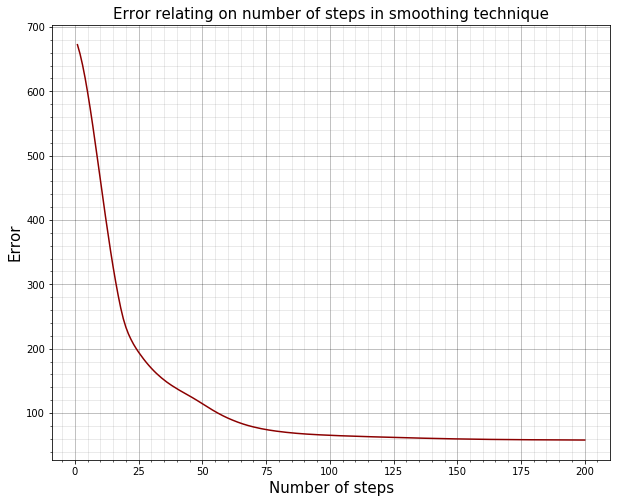

In [56]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(func_smooth)), func_smooth, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

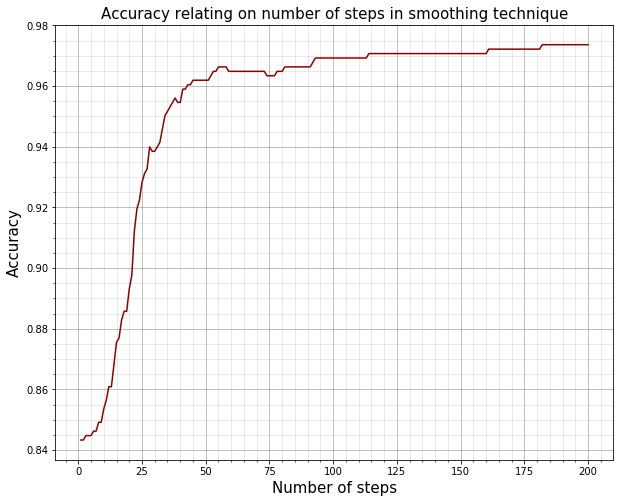

In [58]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy_smooth)), accuracy_smooth, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# ADMM 2.0

Во всех реализованных алгоритмах (ADMM by Boyd, Subgradient Descent, Gradient Projection Method, Accelerated Gradient Decsent with smoothing technique) получается, что свободный член $w_0 = 0$. Это также потдверждает SVM из sklearn. Поэтому реализуем ADMM метод, предложенный в классе, считая $w_0 = 0$.

Получается такая задача:

$$\min\limits_{w} \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}\left[1 - y_iw^Tx_i)\right]_+ = \min\limits_{w} f(w) + \hat{h}(w),$$

здесь $\hat{h}(w) = [w]_+$. Введем матрицу $A$ вида:

$$A = \begin{pmatrix}y_1x_1^1 & y_1 x_1^2 & y_1 x_1^3 & \dots & y_1 x_1^n\\
y_2x_2^1 & y_2 x_2^2 & y_2 x_2^3 & \dots & y_2 x_2^n\\
y_3x_3^1 & y_3 x_3^2 & y_3 x_3^3 & \dots & y_3 x_3^n\\
\vdots & \vdots & \vdots & \ddots& \vdots\\
y_{\ell}x_{\ell}^1 & y_{\ell} x_{\ell}^2 & y_{\ell} x_{\ell}^3 & \dots & y_{\ell} x_{\ell}^n\\
\end{pmatrix}.$$

Тогда сделав замену $z = Ax$, можем перейти к задаче условной оптимизации:

$$\min\limits_{w} \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}\left[1 - z_i\right]_+ = \min\limits_{w} f(w) + h(z),\\
s.t. Aw = z.$$

Здесь $h(z) = \sum\limits_{i=1}^{\ell} (1-z_i)_+$. Для этой задачи запишем модифицированную функцию Лагранжа:

$$L_r = \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}\left[1 - z_i\right]_+ \frac{1}{2r}\|\lambda + r(Aw - z)\|_2^2 - \frac{\|\lambda\|_2^2}{2r}.$$

Найдем шаг по $w$. Для этого запишем условие оптимальности по $w$:

$$\nabla_w L_r = w + A^T\lambda + rA^TAw - rA^Tz = 0 \Rightarrow w^{k+1} = (I + rA^TA)^{-1}A^T(rz^{k} - \lambda^{k+1}).$$

Найдем шаг по $z$. Задача в данном случае сепарабельна по переменным $z_i$:

$$\alpha \begin{cases}-1, \qquad ~~~~~~z_i < 1\\
[-1, 0],\qquad z_i = 1\\
0, \qquad ~~~~~~~~~z_i > 1\end{cases} - \lambda_i - r(Aw)_i + rz_i = 0 \Rightarrow z_i^{k+1} = \begin{cases}(Aw^{k+1})_i + \frac{\lambda_i^{k} +1}{r}, \qquad (Aw^{k+1})_i + \frac{\lambda_i^{k}}{r} < 1- \frac{1}{r}\\
1,\qquad\qquad\qquad ~(Aw^{k+1})_i + \frac{\lambda_i^{k}}{r} \in \left[1- \frac{1}{r}, 1\right] \\
(Aw^{k+1})_i + \frac{\lambda_i^{k}}{r}, ~~~\qquad (Aw^{k+1})_i + \frac{\lambda_i^{k}}{r} > 1\end{cases}$$

Правило обновления для $\lambda$:

$$\lambda^{k+1} = \lambda^k + r(Aw^{k+1} - z^{k+1})$$

In [89]:
r = 1
alp = 1

In [115]:
A = np.zeros((l, n))
for i in range(l):
    for j in range(n):
        A[i][j] = y[i]*X[i][j]

B = np.linalg.inv(np.eye(n) + A.T.dot(A)).dot(A.T)

def opt_w(z, lmb):
    return B.dot(r*z-lmb)

def opt_z(w, lmb):
    ans = np.zeros(l)
    a = A.dot(w)+lmb/r
    for i in range(l):
        if a[i] < 1-alp/r:
            ans[i] = a[i] + alp/r
        elif a[i] > 1:
            ans[i] = a[i]
        else:
            ans[i] = 1
    return ans

def f(w):
    ans = 1/2*np.linalg.norm(w)**2
    for i, x_i in enumerate(X):
        if (1 - y[i]*w.T.dot(x_i) >= 0):
            ans += alp*(1 - y[i]*w.T.dot(x_i))
    return ans

print(A)

[[ 0.860107  0.111111  1.       ...  0.555556  1.        1.      ]
 [ 0.859671  0.111111  0.333333 ...  0.555556  0.777778  1.      ]
 [ 0.857807  0.555556  1.       ...  0.555556  1.        1.      ]
 ...
 [-0.876716 -0.111111  1.       ...  0.555556  1.       -0.777778]
 [-0.875424 -0.333333  0.555556 ...  1.        0.111111 -1.      ]
 [-0.875424 -0.333333  0.555556 ...  1.       -0.333333 -1.      ]]


In [116]:
func_admm2 = []
accuracy_admm2 = []
w = np.ones(n)
z = np.zeros(l) 
u = np.zeros(l)
eps = f(w)
func_admm2.append(eps)
while eps > 49.615:
    w = opt_w(z, u)
    z = opt_z(w, u)
    u = u + r*(A.dot(w) - z)
    eps = f(w)
    func_admm2.append(eps)
    a = accuracy_score(y, predict(X.dot(w)))
    accuracy_admm2.append(a)

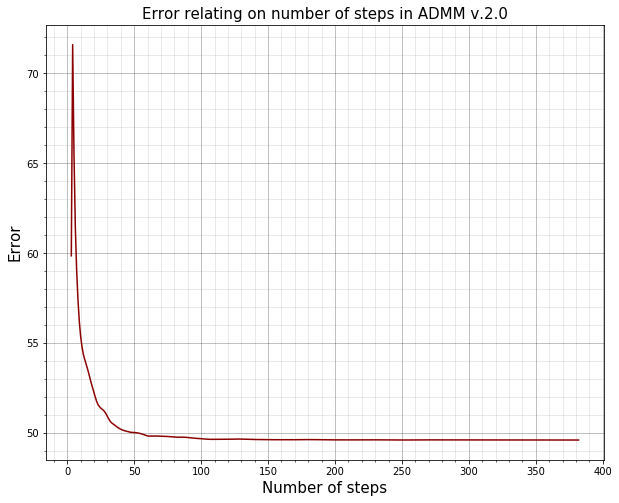

In [117]:
plt.figure(figsize=[10, 8])
plt.plot(range(3, 3+len(func_admm2[2:])), func_admm2[2:], color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in ADMM v.2.0', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

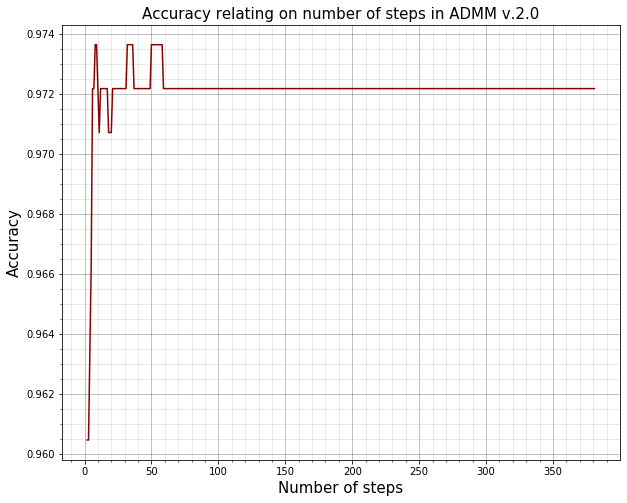

In [118]:
plt.figure(figsize=[10, 8])
plt.plot(range(2, 2+len(accuracy_admm2[1:])), accuracy_admm2[1:], color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in ADMM v.2.0', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Subgradient descent

$$f(w, w_0) = \frac{1}{2}\|w\|^2_2 + \alpha\sum\limits_{i=1}^{\ell} (1-y_iw^Tx_i + y_iw_0).$$ 

Найдем субградиент данной функции:

$$\left[\partial_{w} f\right]_k = w_k + \sum\limits_{i=1}^{\ell} \begin{cases} -y_ix_i^k, \qquad 1-y_iw^Tx_i + y_iw_0 > 0\\
[0, -y_ix_i], \qquad 1-y_iw^Tx_i + y_iw_0 = 0\\
0, \qquad 1-y_iw^Tx_i + y_iw_0 < 0\end{cases}$$

$$\left[\partial_{w_0} f\right]_k = \sum\limits_{i=1}^{\ell} \begin{cases} y_i, \qquad 1-y_iw^Tx_i + y_iw_0 > 0\\
[0, y_i], \qquad 1-y_iw^Tx_i + y_iw_0 = 0\\
0, \qquad 1-y_iw^Tx_i + y_iw_0 < 0\end{cases}$$

In [89]:
def grad_f(w):
    ans = np.zeros(n+1)
    v = w[:-1]
    v_0 = w[-1]
    for k in range(n):
        ans[k] += w[k]
    for i, x_i in enumerate(X):
        temp = 1 - y[i]*v.T.dot(x_i) + y[i]*v_0
        if temp > 0:
            for k in range(n):
                ans[k] -= y[i]*x_i[k]
            ans[n] += y[i]
        elif temp == 0:
            for k in range(n):
                if (-y[i]*x_i[k] > 0):
                    ans[k] += np.random.uniform(0, -y[i]*x_i[k])
                elif (-y[i]*x_i[k] < 0):
                    ans[k] += np.random.uniform(-y[i]*x_i[k], 0)
            if y[i] > 0:
                ans[n] += np.random.uniform(0, y[i])
            elif y[i] < 0:
                ans[n] += np.random.uniform(y[i], 0)
    return ans

In [99]:
func_sub = []
accuracy_sub = []
w = np.ones(n+1)
w[-1] = 0
eps = L(w)
func_sub.append(eps)
while (eps > 50):
    a = grad_f(w)
    a = a/np.linalg.norm(a)
    w = w - 0.001*a
    k+=1
    eps = L(w)
    v = w[:-1]
    v_0 = w[-1]
    a = accuracy_score(y, predict(X.dot(v)-v_0))
    accuracy_sub.append(a)
    func_sub.append(eps)

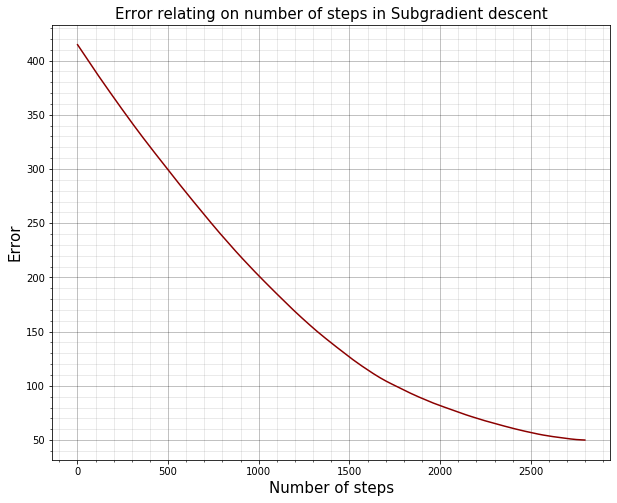

In [100]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(func_sub)), func_sub, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in Subgradient descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

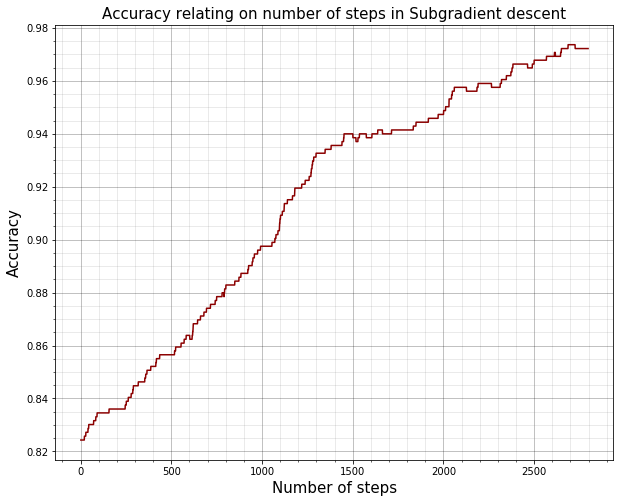

In [101]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy_sub)), accuracy_sub, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in Subgradient descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Gradient projection method

В лекциях Воронцова получена двойственная задача для soft SVM:

http://www.machinelearning.ru/wiki/images/a/a0/Voron-ML-Lin-SVM.pdf

Двойственная задача имеет вид:

$$\min\limits_{\lambda} g(\lambda) = \min\limits_{\lambda}\left[ -\sum\limits_{i=1}^{\ell} \lambda_i+\frac{1}{2}\sum\limits_{i,j=1}^{\ell} \lambda_i\lambda_j y_i y_j (x_i, x_j)\right] = \min\limits_{\lambda}\left[\mathbf{1}^T\lambda - \frac{1}{2}\lambda^TK\lambda\right]\\
s.t. 0 \leq \lambda \leq \textbf{1}/\alpha\\
\lambda^Ty = 0$$

Если введем множество $\Omega = \{\lambda: 0 \leq \lambda \leq \textbf{1}/\alpha, 
\lambda^Ty = 0\}$, то метод проекции градиента имеет вид:

$$\lambda^{k+1} = \pi_{\Omega}\left[\lambda^k - \alpha_k \nabla g(\lambda^k)\right].$$

Здесь $\nabla g(\lambda) = K \lambda - \textbf{1}$, т.к. матрица $K$ симметричная. По оптимальному вектору $\lambda$ восстанавливаются исходные значения $w$:

$$w = \sum\limits_{i=1}^{\ell}\lambda_iy_ix_i,\qquad w_0 = (w,x_i) - y_i \text{ (for any i)}$$


In [121]:
K = np.zeros((l, l))
for i in range(l):
    for j in range(l):
        K[i][j] = y[i]*y[j]*X[i].dot(X[j])
print(K)

[[ 7.66571079  2.35669309  7.49089327 ...  0.91259632 -1.55542651
  -0.93814135]
 [ 2.35669309  4.01063929  2.62632058 ...  0.59199222 -0.4439346
  -0.91307013]
 [ 7.49089327  2.62632058  7.56299502 ...  0.9886868  -1.62748729
  -1.05958475]
 ...
 [ 0.91259632  0.59199222  0.9886868  ...  5.42295351  3.10083234
   2.92799407]
 [-1.55542651 -0.4439346  -1.62748729 ...  3.10083234  3.74167609
   3.47007103]
 [-0.93814135 -0.91307013 -1.05958475 ...  2.92799407  3.47007103
   3.74167609]]


In [148]:
C = 1 #C = alp

In [143]:
def g(lmb):
    ans = -np.sum(lmb)
    a = K.dot(lmb)
    ans += lmb.dot(a)/2
    return ans

def grad_g(lmb):
    return K.dot(lmb) - np.ones(l)

def projection(lmb):
    ans = lmb
    one = y
    a = np.linalg.norm(ans)
    b = np.linalg.norm(one)
    cos = ans.dot(one)/a/b
    p = a*cos/b*one
    ans = ans - p
    for i in range(l):
        if ans[i] < 0:
            ans[i] = 0
        elif ans[i] > C:
            ans[i] = C
    return ans

In [144]:
func_proj = []
accuracy_proj = []
lmb = np.random.uniform(0,1,l)
eps = g(lmb)
func_proj.append(eps)
for i in range(1000):
    lmb = lmb - 0.0001*grad_g(lmb)
    lmb = projection(lmb)
    eps = g(lmb)
    w = np.zeros(n)
    for i, x_i in enumerate(X):
        w += lmb[i]*y[i]*x_i
    w_0 = w.dot(X[0]) - y[0]
    a = accuracy_score(y, predict(X.dot(w)-w_0))
    accuracy_proj.append(a)
    func_proj.append(eps)

In [145]:
w = np.zeros(n)
for i, x_i in enumerate(X):
    w += lmb[i]*y[i]*x_i
w_0 = w.dot(X[0]) - y[0]
accuracy_score(y, predict(X.dot(w)-w_0))

0.9707174231332357

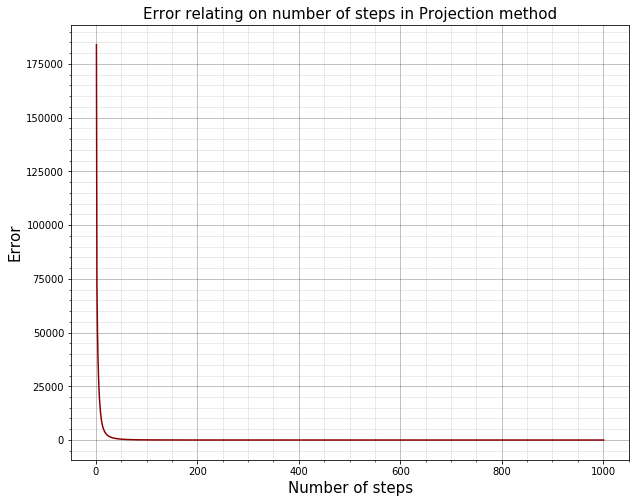

In [146]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(func_proj)), func_proj, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in Projection method', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

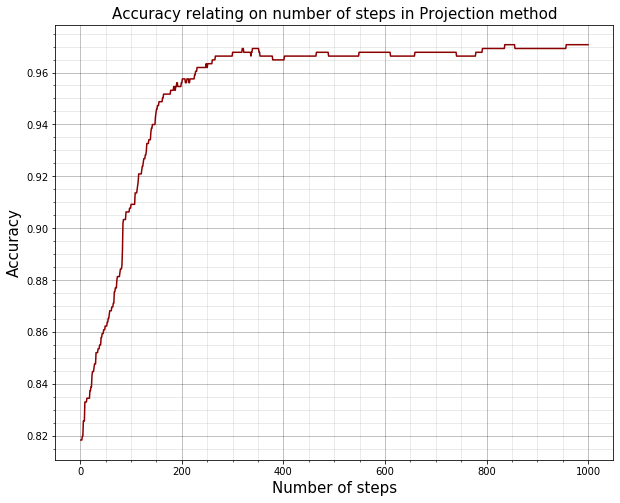

In [147]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy_proj)), accuracy_proj, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in Projection method', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Conclusion

Все методы дают очень хорошее качество аппроксимации (порядка $0,97$). Самым быстрым методом является ADMM v.2.0 (около $50$ шагов для достижения точности $0,97$). Самыми медленными являются метод проекции градиента и субградиентный спуск (порядка $1000-2000$ шагов для достижения точности $0,97$). 

# Эффективные алгоритмы для вспомагательных задач бинарной классификации

# Effective algorithms for binary classification problems

Решается задача бинарной классификации.
Для этого используется классификатор на базе l1-регуляризованной логистической регрессии. 
Про все это можно прочитать, например, тут:
https://habr.com/ru/company/ods/blog/323890/#lineynyy-klassifikator

Чтобы "обучить" модель нужно решить задачу оптимизации:
$$
\min_{w\in R^n} \{ \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1
$$

Вы изучили достаточно много методов для решения таких задач:


*   Реализуйте метод проксимального градиентного спуска для этой задачи (3 балла)
*   Реализуйте метод ADMM для этой задачи (3 балла)


*   Реализуйте быстрый градиентный спуск используя метод сглаживания (5 баллов)
*   Реализуйте метод субградиентного спуска для этой задачи (3 балла)


*   Представьте эту задачу в виде, для которого можно использовать метод условного градиента или метод проекции градиента. Реализуйте их (3 балла).




*   Проведите расчеты для данных a8a (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) (3 балла)
*   Сравните скорость сходимости методов для этого инстанса задачи (то есть конкретно для этого набора данных) (2 балла)








# Data reading

In [242]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [243]:
l_train = 22696 #количество объектов в train
l_test = 9865 #количество объектов в test
n = 123 #количество признаков

In [244]:
y_train = np.zeros((l_train,))
y_test = np.zeros((l_test,))
X_train = np.zeros((l_train, n))
X_test = np.zeros((l_test, n))

In [245]:
f = open('train.txt', 'r')
for i, line in enumerate(f):
    line = line.split(' ')
    for c in line[:-1]:
        if c == '+1':
            y_train[i] = 1
        elif c == '-1':
            y_train[i] = -1
        else:
            c = c.split(':')
            X_train[i][int(c[0]) - 1] = int(c[1])

In [246]:
print(X_train[0], '|', y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] | -1.0


In [247]:
f = open('test.txt', 'r')
for i, line in enumerate(f):
    line = line.split(' ')
    for c in line[:-1]:
        if c == '+1':
            y_test[i] = 1
        elif c == '-1':
            y_test[i] = -1
        else:
            c = c.split(':')
            X_test[i][int(c[0]) - 1] = int(c[1])

In [248]:
print(X_test[0], '|', y_test[0])

[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] | -1.0


# Proximal descent

Нужно решить задачу $\sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda \|w\|_1 = f(w) + h(w)$.

$\text{prox}_{\mu}(w) = \text{argmin}_u\left(h(u) + \frac{\mu}{2}\|u-w\|_2^2\right) = \text{argmin}_u\left(\lambda \|u\|_1 + \frac{\mu}{2}\|u-w\|_2^2\right).$ Найдем явный вид $\text{prox}$-функции. Для этого нужно решить задачу оптимизации. Задача является сепарабельной по переменным, решаем для каждой задачи отдельно.

$$\lambda \partial|u_i| \begin{cases}1, ~~~~~~~~~ \qquad u_i>0\\
-1, ~~~~~~ \qquad u_i < 0\\
[-1,1], \qquad u_i = 0\end{cases} + \mu(u_i-w_i) = 0 \Rightarrow u_i = \begin{cases}w_i - \frac{\lambda}{\mu}, \qquad w_i > \frac{\lambda}{\mu}\\
w_i + \frac{\lambda}{\mu}, \qquad w_i < -\frac{\lambda}{\mu}\\
0, ~~~~~~~~~~\qquad w_i \in [-\frac{\lambda}{\mu}, \frac{\lambda}{\mu}]\end{cases}.$$
Тогда правило обновления имеет следующий вид:

$$w_{k+1} = \text{prox}_{\mu}\left[w_k - \alpha_k\nabla f(w_k)\right].$$

Нужно найти градиент функции $f(w)$. Он имеет вид:
$$\left[\nabla f(w)\right]_k = \sum\limits_{i=1}^l \frac{-y_ix_{i}^k\exp{\left(-y_i w^Tx_i\right)}}{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }.$$ Теперь все готово к реализации метода.

In [65]:
def grad_f(w, X, y):
    ans = np.zeros(n)
    for k in range(n):
        for i, x_i in enumerate(X):
            ans[k] += (-y[i]*x_i[k]*math.exp(-y[i]*w.T.dot(x_i)))/(1+math.exp(-y[i]*w.T.dot(x_i)))
    return ans

def opt_u(w):
    ans = np.zeros(n)
    for i in range(n):
        if w[i] > lmbd/mu:
            ans[i] = w[i] - lmbd/mu
        elif w[i] < -lmbd/mu:
            ans[i] = w[i] + lmbd/mu
        else:
            ans[i] = 0
    return ans
            
def prox(w, X, y):
    step = w - alp*grad_f(w, X, y) 
    return opt_u(step)

In [82]:
lmbd = 5
mu = 1000
alp = 0.0001

In [83]:
error_prox = []
weights = []

In [85]:
w_1 = np.zeros(n)
w_0 = np.ones(n)
weights.append(w_1)
eps = np.linalg.norm(w_0 - w_1)
error_prox.append(eps)
while (eps > 0.1):
    w_0 = w_1
    w_1 = prox(w_1, X_train, y_train)
    eps = np.linalg.norm(w_0 - w_1)
    weights.append(w_1)
    error_prox.append(eps)

In [249]:
import matplotlib.pyplot as plt

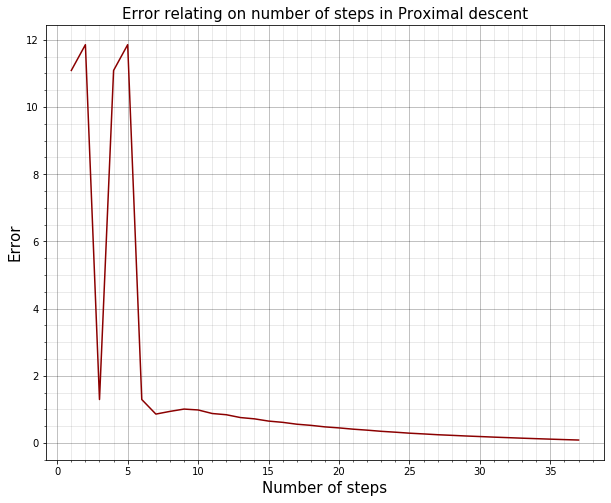

In [100]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(error_prox)), error_prox, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

Исследуем качество аппроксимации на тестовой выборке.

In [96]:
def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

from sklearn.metrics import accuracy_score
accuracy = []
for i in range(len(weights)):
    a = accuracy_score(y_test, predict(X_test.dot(weights[i])))
    accuracy.append(a)

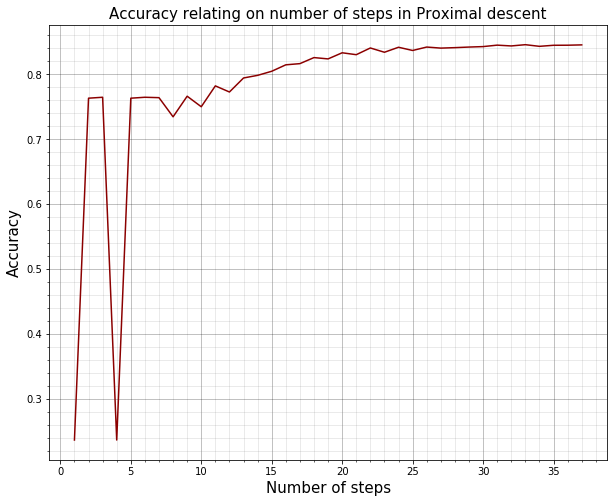

In [99]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy)), accuracy, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in Proximal descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# ADMM

Нужно решить задачу $\sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda \|w\|_1 = f(w) + h(w)$. Перейдем к задаче, которая применима для ADMM: 
$$\begin{cases}\min\limits_{w, u}\sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda \|u\|_1 = \min\limits_{w, u} f(w) + h(u)\\
w=u\end{cases}.$$
Модифицированный лагранжиан имеет вид:
$$\hat{L}_r = f(w)+h(u) + \frac{1}{2r}\|\nu + r(w-u)\|_2^2 - \frac{\|\nu\|_2^2}{2r}.$$
Шаги метода ADMM:

- $w^{k+1} = \text{argmin}_w\hat{L}_r(w, u^k, \nu^k)$

- $u^{k+1} = \text{argmin}_u\hat{L}_r(w^{k+1}, u, \nu^k)$

- $\nu^{k+1} = \nu^k + r(w^{k+1} - u^{k+1})$

Заметим, что задача оптимизации по $w$ имеет вид: $\nabla f(w) + \nu^k + r(w - u^k) = 0.$ Эта задача не решается аналитически, поэтому для ее решения будем использовать модуль scipy.optimize.

Решим задачу для $u$. Она имеет вид
$$\min\limits_{u}\lambda\|u\|_1 + \frac{1}{2r}\|\nu + r(w-u)\|_2^2.$$
Задача сепарабельна по переменным. Условие оптимальности имеет вид
$$\lambda \partial |u_i| - \left(\nu_i + r(w_i-u_i)\right) = 0 \Rightarrow \lambda \begin{cases}1, \qquad\qquad u_i > 0\\
-1, ~~~~~~\qquad u_i < 0\\
[-1,1], \qquad u_i = 0\end{cases} - \left(\nu_i + r(w_i-u_i)\right) = 0 \Rightarrow u_i = \begin{cases}w_i +\nu_i/r -\lambda/r, \qquad w_i+\nu_i/r  > \lambda/r\\
w_i + \nu_i/r + \lambda/r, \qquad  w_i+\nu_i/r  < -\lambda/r\\
0, ~~~~\qquad\qquad\qquad w_i +\nu_i/r \in [-\lambda/r, \lambda/r]\end{cases}.$$

In [99]:
lmbd = 100
mu = 1000
r = 1

In [100]:
def grad_w(w, u, v):
    ans = np.zeros(n)
    for k in range(n):
        for i, x_i in enumerate(X_train):
            ans[k] += (-y_train[i]*x_i[k]*math.exp(-y_train[i]*w.T.dot(x_i)))/(1+math.exp(-y_train[i]*w.T.dot(x_i)))
            ans[k] += (v[k] +r*(w[k] - u[k]))
    return ans

def opt_w(w,u,v):
    for j in range(50):
        w = w - 0.000001*grad_w(w,u,v)
    return w

def opt_u(w, u, v):
    ans = np.zeros(n)
    for k in range(n):
        if (w[k] + v[k]/r > lmbd/r):
            ans[k] = w[k] + v[k]/r - lmbd/r
        elif (w[k] + v[k]/r < -lmbd/r):
            ans[k] = w[k] + v[k]/r + lmbd/r
        else:
            ans[k] = 0
    return ans

def opt_v(w, u, v):
    return v + r*(w - u)

In [108]:
error_admm = []
weights = []
w_1 = np.ones(n)
w_0 = np.zeros(n)
u = np.zeros(n)
v = np.zeros(n)
weights.append(w_1)
eps = np.linalg.norm(w_0 - w_1)
error_admm.append(eps)
k=0
while (eps > 0.01):
    w_0 = w_1
    w_1 = opt_w(w_1, u, v)
    u = opt_u(w_1, u, v)
    v = opt_v(w_1, u, v)
    eps = np.linalg.norm(w_0 - w_1)
    weights.append(w_1)
    error_admm.append(eps)

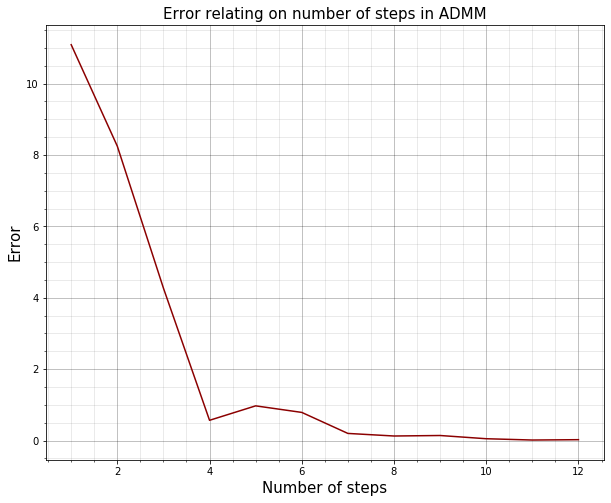

In [116]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(error_admm)), error_admm, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

In [112]:
def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

from sklearn.metrics import accuracy_score
accuracy = []
for i in range(len(weights)):
    a = accuracy_score(y_test, predict(X_test.dot(weights[i])))
    accuracy.append(a)

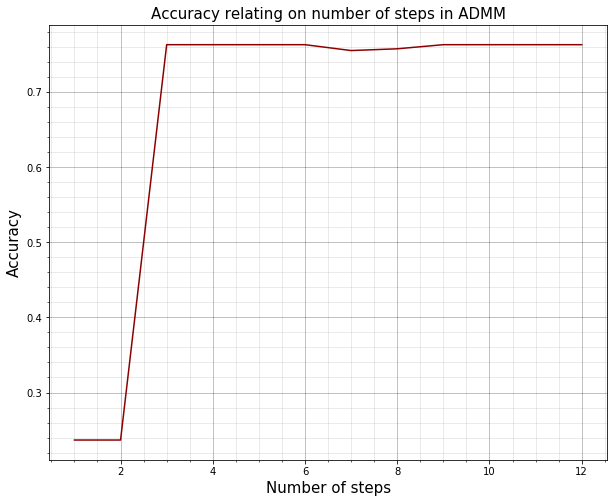

In [113]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy)), accuracy, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in ADMM', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Fast gradient descent with smoothing technique

Перейдем к эквивалентной записи функции:
    $$F(w) = \sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda \|w\|_1 = \sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda\max\limits_{-1 \leq u_i \leq 1}\sum\limits_{k=1}^n u_kw_k.$$
Используя сглаживание, получаем
$$\hat{F}(w)=\sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda\max\limits_{-1 \leq u_i \leq 1}\sum\limits_{k=1}^n u_kw_k - \frac{\mu\|u\|_2^2}{2}.$$
Найдем явный вид этой функции, решив оптимизационную задачу:
$$\min\limits_{-1 \leq u_i \leq 1} \frac{\mu\|u\|_2^2}{2} -\lambda\sum\limits_{k=1}^n u_kw_k.$$
Запишем Лагранжиан для данной задачи:
$$L(u, \alpha, \beta) = \frac{\mu\|u\|_2^2}{2} -\lambda \sum\limits_{k=1}^n u_kw_k + \sum\limits_{i=1}^n\alpha_i(u_i-1) -\sum\limits_{i=1}^n\beta_i(u_i+1),$$
при условии $\alpha_i(u_i - 1) = 0, \beta_i(1+u_i) = 0.$


Лагранжиан сепарабелен по переменным, возьмем производную $L$ по $u_i$:
$$L_{u_i} = \mu u_i - \lambda w_i + \alpha_i - \beta_i=0 \Rightarrow u_i = \frac{\lambda w_i + \beta_i - \alpha_i}{\mu}.$$
Здесь получаются следующие случаи, учитывая ограничения:
$$u_i = \begin{cases} 1, ~~~~\qquad \frac{\lambda w_i}{\mu} > 1\\
-1, \qquad ~\frac{\lambda w_i}{\mu} < -1\\
\frac{\lambda w_i}{\mu},\qquad \frac{\lambda w_i}{\mu} \in [-1,1] \end{cases}.$$

Таким образом, мы нашли оптимальные значения $u_i$, а значит, определили $\hat{F}(w)$^
$$\hat{F}(w) = \sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) }+ \lambda\left<u_{opt}, w\right> - \frac{\mu\|u_{opt}\|_2^2}{2}.$$
Выпишем расчетный формулы быстрого градиентного спуска для сглаженной задачи. 

Нужно знать градиент $\hat{F}(w)$:
$$\left[\nabla \hat{F}(w)\right]_k = \sum\limits_{i=1}^l \frac{-y_ix_{i}^k\exp{\left(-y_i w^Tx_i\right)}}{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) } + \lambda (u_{opt})_k$$

- Здесь $d_2(u) \geq \frac{\|u\|^2_2}{2} \Rightarrow \sigma_2 = 1.$ 
- Так как $\lambda\left<u_{opt}, w\right> - \frac{\mu\|u_{opt}\|_2^2}{2} = \left<u_{opt}, \lambda Iw\right> - \frac{\mu\|u_{opt}\|_2^2}{2}, то L_{\mu} = \frac{\lambda\|I\|_{1,2}^2}{\mu \sigma_2} = \frac{\lambda}{\mu\sigma_2}.$ Тогда градиент сглаженной функции есть $L = L_{\mu} + L_{f}.$

Выпишем шаги быстрого градиентного спуска:

- $Compute~\hat{F}(w_k)~and~\nabla \hat{F}(w_k)$

- $Find~z_k = T_Q(w_k) = \text{argmin}_{z}\left[\nabla^T \hat{F}(w_k)(z-w_k)+\frac{L}{2}||z-w_k||_2^2\right].$

Найдем, как вычислять оптимальное $z$. Приравняем градиент по $z$  к нулю

$$\left[\nabla \hat{F}(w)\right] + L(z - w_k) = 0 \Rightarrow z_k = w_k - \frac{1}{L}\left[\nabla \hat{F}(w)\right]. $$

Здесь $\hat{F}(w_k) = \sum\limits_{i=1}^l \ln{ \left(1+\exp{\left(-y_i w_k^Tx_i\right)}\right) }+ \lambda\left<u_{opt}, w_k\right> - \frac{\mu\|u_{opt}\|_2^2}{2}, \left[\nabla \hat{F}(w)\right]_k = \sum\limits_{i=1}^l \frac{-y_ix_{i}^k\exp{\left(-y_i w^Tx_i\right)}}{ \left(1+\exp{\left(-y_i w^Tx_i\right)}\right) } + \lambda (u_{opt})_k.$

- $Find~r_k = \text{argmin}_r\left[\frac{L}{\sigma_2}d(r) +  \sum\limits_{i=0}^k\alpha_i\left(\hat{F}(w_i) + \nabla^T\hat{F}(w_i)(r-w_i)\right)\right] = \text{argmin}_r \left[\frac{L}{2}||r||_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}\left(\hat{F}(w_i) + \nabla^T \hat{F}(w_i)(r-w_i)\right)\right].$

Приравняем градиент по $r$ нулю:
$$Lr + \sum\limits_{i=1}^k \frac{i+1}{2} \nabla\hat{F}(w_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=1}^k \frac{i+1}{2} \nabla\hat{F}(w_i).$$

- $Set~w_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$

In [83]:
lmbd = 1
mu = 1
L = 100000
mas_grad_F = []
mas_F = []
errors_smooth = []
weights = []

In [84]:
def grad_F(w, u):
    ans = np.zeros(n)
    for k in range(n):
        for i, x_i in enumerate(X_train):
            ans[k] += (-y_train[i]*x_i[k]*math.exp(-y_train[i]*w.T.dot(x_i)))/(1+math.exp(-y_train[i]*w.T.dot(x_i)))+lmbd*u[k]
    return ans

def opt_z(w, u):
    return w - 1/L*grad_F(w, u)

def opt_r(w):
    sum = 0
    for i in range(k + 1):
        sum += (i+1)/2.0*(mas_grad_F[i])
    return -1.0/L*sum

def F(w, u): 
    ans = 0
    for i, x_i in enumerate(X_train):
        a = w.dot(x_i)
        a = math.exp(-y_train[i]*a)
        t = math.log(1+a)
        ans += (t +lmbd*w.T.dot(u)-mu/2*np.linalg.norm(u)**2)
    return ans

def opt_u(w):
    ans = np.zeros(n)
    for i in range(n):
        if (lmbd*w[i] < mu and lmbd*w[i] > -mu):
            ans[i] = lmbd*w[i]/mu
        elif (lmbd*w[i] >= mu):
            ans[i] = 1
        else:
            ans[i] = -1
    return ans


In [85]:
z_opt = np.zeros(n)
r_opt = np.zeros(n)
w_0 = np.zeros(n)
w_1 = np.ones(n)
weights.append(w_1)
u_opt = opt_u(w_1)
er = np.linalg.norm(w_0 - w_1)
k=0
while er > 0.01:
    w_0 = w_1
    gradient = grad_F(w_1, u_opt)
    z_opt = w_1 - gradient/L
    r_opt = r_opt - float((k+1))*gradient/(2*L)
    w_1 = 2*r_opt/(i+3) + (i+1)*z_opt/(i+3)
    u_opt = opt_u(w_1)
    k+=1
    er = np.linalg.norm(w_0 - w_1)
    weights.append(w_1)
    errors_smooth.append(er)

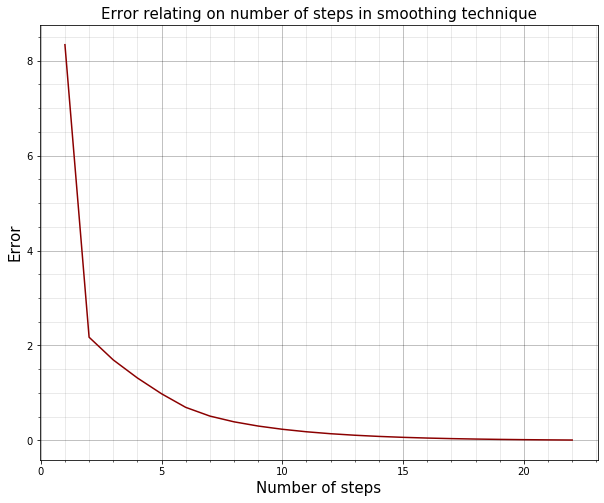

In [87]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(errors_smooth)), errors_smooth, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

In [88]:
def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

from sklearn.metrics import accuracy_score
accuracy = []
for i in range(len(weights)):
    a = accuracy_score(y_test, predict(X_test.dot(weights[i])))
    accuracy.append(a)

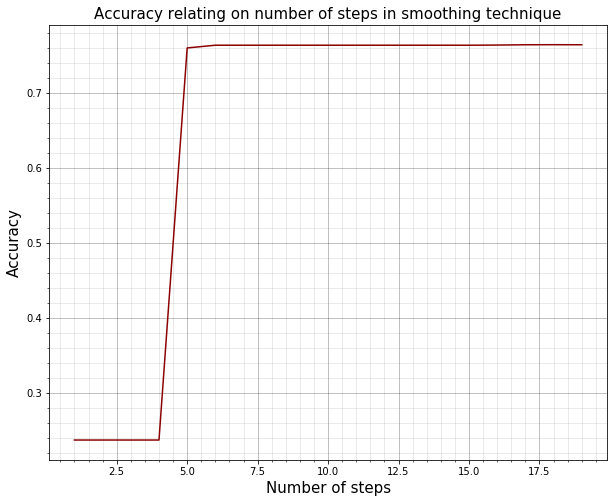

In [119]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy)), accuracy, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Subgradient descent

Субградиент данной функции вычисляется следующим образом:

$$\partial\left[f(w) + h(w)\right] = \partial f(w) + \partial h(w).$$

Здесь $\partial f(w) = \nabla f(w),$ который уже вычислялся ранее и определяется однозначно. Также субградиент $\partial h(w)$ вычисляется по формуле:

$$\left[\partial h(w)\right]_k = \begin{cases}1,\qquad \qquad w_i > 0\\
-1, ~~~~~~\qquad w_i < 0\\
[-1,1], \qquad w_i = 0\end{cases}.$$

При вычислении этого субдифференциала может возникнуть неодозначность. В случае, если нужно вычислить субдифференциал в точке, где $w_k=0$, то субградиент будет по этой координате будет выбираться произвольно из отрезка $[-1,1]$ из равномерного распределения. 

In [84]:
lmbd = 1
errors_sub = []
weights = []

In [85]:
def grad_f(w):
    ans = np.zeros(n)
    for k in range(n):
        for i, x_i in enumerate(X_train):
            ans[k] += (-y_train[i]*x_i[k]*math.exp(-y_train[i]*w.T.dot(x_i)))/(1+math.exp(-y_train[i]*w.T.dot(x_i)))
    return ans

def grad_h(w):
    ans = np.zeros(n)
    for k in range(n):
        if (w[k] > 0):
            ans[k] = lmbd
        elif (w[k] < 0):
            ans[k] = -lmbd
        else:
            ans[k] = lmbd*np.random.uniform(-1,1,1)
    return ans

In [95]:
w_1 = np.ones(n)
w_0 = np.zeros(n)
weights.append(w_1)
eps = np.linalg.norm(w_0 - w_1)
errors_sub.append(eps)
k = 0
while (eps > 0.1):
    w_0 = w_1
    a = grad_f(w_1) + grad_h(w_1)
    a = a/np.linalg.norm(a)
    w_1 = w_1 - 1/(k+1)**0.5*a
    k+=1
    eps = np.linalg.norm(w_0 - w_1)
    weights.append(w_1)
    errors_sub.append(eps)

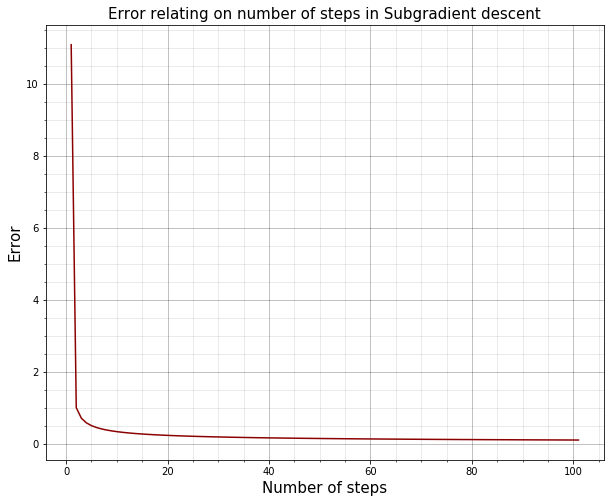

In [87]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(errors_sub)), errors_sub, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in Subgradient descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

In [88]:
def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

from sklearn.metrics import accuracy_score
accuracy = []
for i in range(len(weights)):
    a = accuracy_score(y_test, predict(X_test.dot(weights[i])))
    accuracy.append(a)

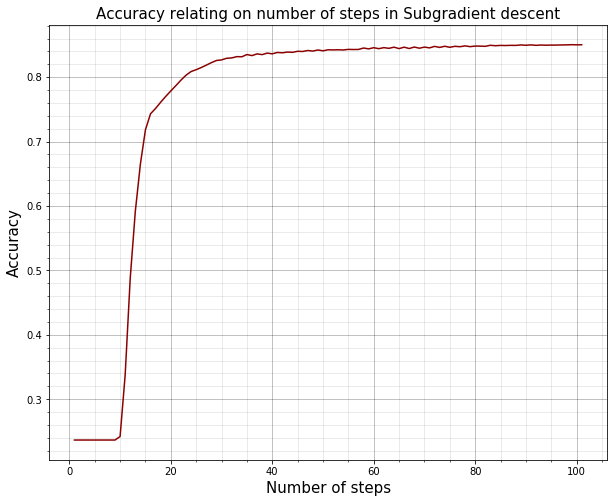

In [89]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy)), accuracy, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in Subgradient descent', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Gradient projection method

Задача вида $\min\limits_{w} L(w) + \lambda \|w\|_1$ экивавлентна задаче $$\min\limits_{w^+, w^- \geq 0} L(w^+ - w^-) + \lambda \|w^+ + w^-\|_1.$$

Здесь $w^+ = \max{w, 0}, w^- = -\min{w, 0}$. В такой постановке задача пригодна для метода проекции градиента. Шаг алгоритма будет представляться в виде:

$$\begin{pmatrix} w^+\\
w^-\end{pmatrix}_{k+1} = \left[\begin{pmatrix} w^+\\
w^-\end{pmatrix}_k - \alpha_k\begin{pmatrix} \nabla L_{w^+} (w^+ - w^-) + \lambda \\ 
\nabla L_{w^-} (w^+ - w^-) + \lambda \end{pmatrix}\right]^+,$$

где $[]^+$ означает проекцию на положительный ортант. 

In [253]:
def grad_L_pos(w_pos, w_neg):
    ans = np.zeros(n)
    w = w_pos - w_neg
    for k in range(n):
        for i, x_i in enumerate(X_train):
            ans[k] += (-y_train[i]*x_i[k]*math.exp(-y_train[i]*w.T.dot(x_i)))/(1+math.exp(-y_train[i]*w.T.dot(x_i)))
            ans[k] += lmbd
    return ans

def grad_L_neg(w_pos, w_neg):
    ans = np.zeros(n)
    w = w_pos - w_neg
    for k in range(n):
        for i, x_i in enumerate(X_train):
            ans[k] -= (-y_train[i]*x_i[k]*math.exp(-y_train[i]*w.T.dot(x_i)))/(1+math.exp(-y_train[i]*w.T.dot(x_i)))
            ans[k] += lmbd
    return ans

def projection(w):
    for k in range(n):
        if w[k] < 0:
            w[k] = 0
    return w

def L_and_L1(w):
    ans = 0
    for i, x_i in enumerate(X_train):
        ans += math.log(1+math.exp(-y_train[i]*w.T.dot(x_i)))
    ans += + lmbd*np.linalg.norm(w, ord=1)
    return ans

In [254]:
lmbd = 0.1
errors_proj = []
weights = []

In [255]:
w_1_pos = np.random.uniform(0, 0.1, n)
w_1_neg = np.random.uniform(0, 0.1, n)
w_0_pos = np.zeros(n)
w_0_neg = np.zeros(n)
w_1 = w_1_pos - w_1_neg
w_0 = w_0_pos - w_0_neg
weights.append(w_1_pos - w_1_neg)
eps = L_and_L1(w_1)
errors_proj.append(eps)
k = 0
for _ in range(25):
    w_0_pos = w_1_pos
    w_0_neg = w_1_neg
    w_1_pos = w_1_pos - 0.000001*grad_L_pos(w_1_pos, w_1_neg)
    w_1_neg = w_1_neg - 0.000001*grad_L_neg(w_1_pos, w_1_neg)
    w_1_pos = projection(w_1_pos)
    w_1_neg = projection(w_1_neg)
    w_1 = w_1_pos - w_1_neg
    w_0 = w_0_pos - w_0_neg
    weights.append(w_1)
    eps = L_and_L1(w_1)
    k+=1
    errors_proj.append(eps)

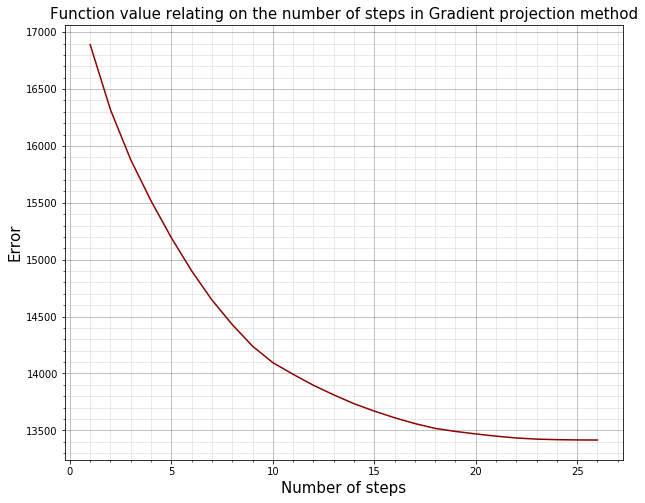

In [259]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(errors_proj)), errors_proj, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Function value relating on the number of steps in Gradient projection method', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

In [223]:
def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

from sklearn.metrics import accuracy_score
accuracy = []
for i in range(len(weights)):
    a = accuracy_score(y_test, predict(X_test.dot(weights[i])))
    accuracy.append(a)

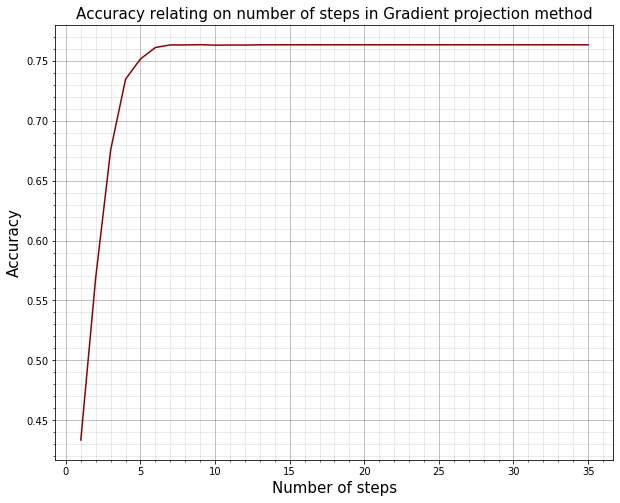

In [224]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy)), accuracy, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in Gradient projection method', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Вывод

Сравним реализованные методы по скорости сходимости. Для этого сравним, какую точность демонстрируют методы после определенного числа шагов. 

Наилучшей точности достигают методы проксимального спуска и субградиентный спуск. У них также есть тенденция к увеличению точности аппроксимации выборки. Остальные методы выходят на плато с точностью ниже, чем у двух уже перечисленных. 

Также нужно сказать о временных затратах, требуемых для вычислений. Самым неэффективным методом оказался метод ADMM. Это объясняется тем, что кроме основной задачи оптимизации на каждой итерации решалась еще одна подзадача, что и приводит к большому времени, требуемого на выполнение. Самыми быстрыми для расчета оказались методы проксимального спуска и субградиентного спуска, поэтому для них сделано и большее количество итераций, а следовательно, и полученная точность выше.

Все методы требуют очень аккуратной настройки параметров модели. Это объясняется тем, что в выборке представлено очень большое количество объектов. Даже небольшое изменение параметров модели с учетом большого числа объектов приводит к расходимости методов, т.к. методы начинают прыгать вокруг точного решения. Из-за неточности параметров, методы могут не сойтись к решению. 